# Evaluation of models

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  

* Feb2022; March2022 
* Aug2022; tidies notebook


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
from pathlib import Path
import json
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import math
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, precision_recall_fscore_support
from datetime import datetime


from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.helpers.various import concatenating_YAML_via_tags, \
                                    plot_dataset_classes, \
                                    split_train_validate_sets
from source.helpers.learning_pipeline import get_class_distribution, \
                                            plot_from_dict, \
                                            creating_pair_of_clips, \
                                            pair_clips_labels, \
                                            animate_clips
from source.models.learning_misc import train_loop, \
                                        test_loop

from source.models.architectures import basicVGG, TrompNetV1, \
        LeNet5_source00, LeNet5_source01, LeNet5_source02, \
        AlexNet_source00, AlexNet_source01, AlexNet_source02, AlexNet_source03, \
        MobileNetV1, MobileNetV2, \
        SqueezeNet_source0, SqueezeNet_source1, SqueezeNet_source2
        #ShuffleNetV1, ShuffleNetV2 (require 3 channels of input images)

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/data/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'FULL_REPO_MODEL_PATH: {FULL_REPO_MODEL_PATH}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )


PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
FULL_REPO_MODEL_PATH: /home/mx19/repositories/echocardiography/data/models
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results


## 2. Setting variables and loading datasets using pytorch dataloader

In [2]:
##############################
##### Setting up device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:NN" can also be used e.g., "cuda:0"
print(f'Device: {DEVICE}')


# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects'
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects'
# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-20-subjects'
# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects'


TRAINING_SPLITTING = 0.70 #config['ntraining'] #Default
TEST_FRACTION = 0.20
VAL_FRACTION = 1-TRAINING_SPLITTING-TEST_FRACTION
print(f'train_set_size  {TRAINING_SPLITTING}, test_set_size {TEST_FRACTION}, val_test_size {VAL_FRACTION}')

FLAG_RANDOMISE_DATA=True #config['randomise_file_list'] #Default

split_train_validate_sets(  
                        ECHODATASET_PATH, #config['echodataset_path']
                        config['data_list_output_path'], 
                        TRAINING_SPLITTING,
                        TEST_FRACTION,
                        FLAG_RANDOMISE_DATA
                        )

# PRETRANSFORM_IM_SIZE = [64, 64] #[650, 690] original pixel size for VenueGO
PRETRANSFORM_IM_SIZE = [128, 128] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [256, 256] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [512, 512] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = config['pretransform_im_size'] ##DEFAULT

### >> CHANGE DENSE LAYER FEATURES IN VGG3D
### >> `self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128`

##############################
##### Experiments for Basic HYPERPARAMETER Heuristics 

#### TESTS
NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; 
#LEARNING_RATE= 0.00005; 


#################  LEARNING_RATE 
### EXPERIMENT 01,02,03,04
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.0000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00000005; 

#################  BATCH_SIZE_OF_CLIPS with LEARNING_RATE= 0.000005 as it is the best peformance of prevous LRs 
### EXPERIMENT 04,06,07,08
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 2; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 5; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 15; LEARNING_RATE= 0.000005; 

#################  NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP with LEARNING_RATE= 0.000005 and BATCH_SIZE_OF_CLIPS=10
### EXPERIMENT 09,10,11,12
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 2; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 7; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 13; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 20; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 

##TOADD
### * NUMBER_OF_FRAMES_AND PARTICPANTS
### * OPTIMISERS 

# LEARNING_RATE =Trial and Error with diffent values  0.00005; 0.0005; 0.005 and 0.000001; 0.00001; 0.0001; 0.001  


MAX_EPOCHS = 500 #Alternatvely, make use of: config['max_epochs']


##############################
##### Setting up animation
interval_between_frames_in_milliseconds=33.3 ## 1/30=0.033333
frame_per_seconds_for_animated_frames=30


#SUBJECT_ID = '073'
#print(SUBJECT_ID)

### CUDA out of memory 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
#PRETRANSFORM_IM_SIZE = [128, 128] 
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.05 GiB free; 8.53 GiB reserved in total by PyTorch)
## REBOOT MACHINE
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.13 GiB free; 8.53 GiB reserved in total by PyTorch)



##############################
## Setting labels
label_id = ('BKGR', '4CV')



# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=PRETRANSFORM_IM_SIZE),
        transforms.ToTensor(),
    ])
else:
    pretransform = None
    
    #config['use_train_augmentation']#Default
    
    
# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=train_transform, #None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

test_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_test'],
    participant_path_json_list=config['participant_path_json_list_test'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=test_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

val_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=val_transform,
    use_tmp_storage=config['use_tmp_storage']
    )





Device: cuda
train_set_size  0.7, test_set_size 0.2, val_test_size 0.10000000000000003
---------------------------------------------
  FILENAMES_len=28
======= video_filenames: ('/01NVb-003-044/T3/01NVb-003-044-3 echo.mp4', '/01NVb-003-043/T3/01NVb-003-043-3 echo.mp4', '/01NVb-003-048/T2/01NVb-003-048-2 echo.mp4', '/01NVb-003-040/T2/01NVb-003-040-2 echo.mp4', '/01NVb-003-040/T1/01NVb-003-040-1 echo.mp4', '/01NVb-003-046/T1/01NVb-003-046-1 echo.mp4', '/01NVb-003-042/T1/01NVb-003-042-1 echo.mp4', '/01NVb-003-041/T1/01NVb-003-041-1 echo.mp4', '/01NVb-003-045/T2/01NVB-003-045-2 echo.mp4', '/01NVb-003-045/T3/01NVb-003-045-3 echo.mp4', '/01NVb-003-050/T1/01NVb-003-050-1 echo.mp4', '/01NVb-003-041/T2/01NVb-003-041-2 echo.mp4', '/01NVb-003-050/T3/01NVb-003-050-3 echo.mp4', '/01NVb-003-046/T3/01NVb-003-046-3 echo.mp4', '/01NVb-003-042/T3/01NVb-003-042-3 echo.mp4', '/01NVb-003-047/T3/01NVb-003-047-3 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-1 echo.mp4', '/01NVb-003-048/T3/01NVb-003-048-3 echo.

  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects//01NVb-003-048/T3/01NVb-003-048-3 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.121017486668457 nframes=26308 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects//01NVb-003-047/T1/01NVb-003-047-1 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.639684201243103 nframes=20098 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects//01NVb-003-050/T2/01NVb-003-050-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.97112109865596 nframes=27468 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects//01NVb-003-042/T2/01NVb-003-042-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.972611145636726 nframes=11612 
  


## 3. Plotting Class Distribution

/home/mx19/anaconda3/envs/rt-ai-echo-VE/lib/python3.8/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /tmp/pip-req-build-pma2oi4d/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


class_distribution(train_dataset): {'BKGR': 37, '4CV': 37}
class_distribution(test_dataset): {'BKGR': 12, '4CV': 12}
class_distribution(val_dataset): {'BKGR': 8, '4CV': 8}
Number of frames for training datasets 74
Number of frames for testing datasets 24
Number of frames for Validation datasets 16


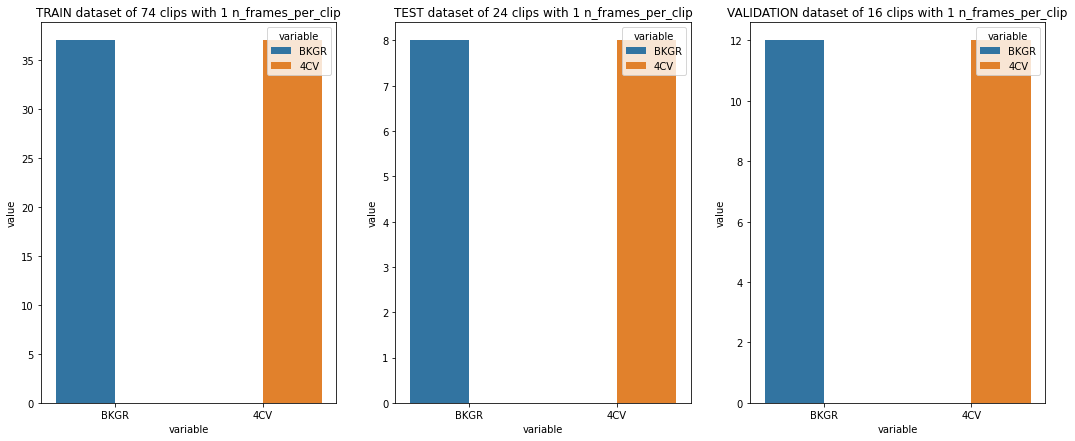

In [3]:
train_set_class_dict = get_class_distribution(train_dataset,label_id)
test_set_class_dict = get_class_distribution(test_dataset,label_id)
val_set_class_dict = get_class_distribution(val_dataset,label_id)


print(f'class_distribution(train_dataset): {train_set_class_dict}')
print(f'class_distribution(test_dataset): {test_set_class_dict}')
print(f'class_distribution(val_dataset): {val_set_class_dict}' )
    
#number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {len(train_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for testing datasets {len(test_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for Validation datasets {len(val_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')

plot_title_train_label= f'TRAIN dataset of {len(train_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(val_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(train_set_class_dict, plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(val_set_class_dict, plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(test_set_class_dict, plot_title=plot_title_val_label, ax=axes[2])
plt.show()

## 5. Displayting frames in the dataloader

In [4]:
print(f'====================================================')
print(f'train_dataset.__len__() = {train_dataset.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)


print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)} BATCHES of BATCH_SIZE_OF_CLIPS {BATCH_SIZE_OF_CLIPS}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} ')
        print(f'          label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'          Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'          Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()


print(f'====================================================')
print(f' test_dataset.__len__() = {test_dataset.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f' validation_dataset.__len__() = {val_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)



train_dataset.__len__() = 74
len(train_dataloader): 4 BATCHES of BATCH_SIZE_OF_CLIPS 20
    BATCH_OF_CLIPS_INDEX : 0 / 3
    sample_batched_labels.size(): torch.Size([20])
    sample_batched_labels.squeeze().size(): torch.Size([20])
    sample_batched_images.size(): torch.Size([20, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 1
   

## 6. Define networks


## 11. Evaluate the model on test dataset

In [5]:
model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858 ## Training curves look good
## PRINT MODEL
print(f'====================================================')
print(model)

print(f' {FULL_REPO_MODEL_PATH}')
model.load_state_dict(torch.load(
    os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth")))
model.to(DEVICE) # Place model on GPU
model.eval()


y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(val_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(DEVICE), sample_batched[1].to(DEVICE)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(val_dataset, label_id))
print(f'y_true_list{y_true_list}')
print(f'y_pred_list{y_pred_list}')


MobileNetV2(
  (stem_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([16, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([16])
{'BKGR': 8, '4CV': 8}
y_true_list[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]
y_pred_list[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]


              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.75      0.75      0.75         8

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16

                    Precision  Recall  F1-score  Support
0                        0.75    0.75      0.75      8.0
1                        0.75    0.75      0.75      8.0
weighted avg/Total       0.75    0.75      0.75      NaN
Avg/Total                 NaN     NaN       NaN     16.0
[[6 2]
 [2 6]]


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

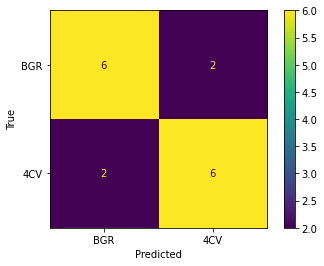

In [6]:
report = classification_report(y_true_list, y_pred_list)
print(report)
# report_support = precision_recall_fscore_support(y_true_list, y_pred_list)
# print(report_support)

def metrics_report_to_df(ytrue, ypred):
    classification_report_df = pd.DataFrame(data=list(precision_recall_fscore_support(y_true_list, y_pred_list)), \
                                         index=['Precision', 'Recall', 'F1-score', 'Support']).T    
    classification_report_df.loc['weighted avg/Total', :] = precision_recall_fscore_support(ytrue, ypred, average='weighted')
    classification_report_df.loc['Avg/Total', 'Support'] = classification_report_df['Support'].sum()
    return(classification_report_df)

classification_report_df = metrics_report_to_df(y_true_list, y_pred_list)
print(classification_report_df)

#################################
### PLOTTING CONFUSION MATRIX
cm=confusion_matrix(y_true_list, y_pred_list)
print(cm)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')





## File size of models: 
```
$HOME/repositories/echocardiography/data/models$ tree -s

.
├── [  201010447]  metric_model.pth
├── [  351538511]  VGG00v00_metric_model.pth
├── [  752946511]  VGG00v01_metric_model.pth
└── [  201010511]  VGG00v02_metric_model.pth

0 directories, 4 files

```